In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
from shapely import wkt

/Users/thijmenvandergeer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv("sensor-location.csv", sep=';')

df[['latitude', 'longitude']] = df['Lat/Long'].str.split(',', expand=True)
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])

df.head()

,Objectummer,Locatienaam,Lat/Long,Breedte,Effectieve breedte,latitude,longitude
0,CMSA-GAKH-01,Kalverstraat t.h.v. 1,"52.372634, 4.892071",8,"6,7",52.372634,4.892071
1,CMSA-GAWW-11,Korte Niezel,"52.374616, 4.899830","3,8","3,4",52.374616,4.899830
2,CMSA-GAWW-12,Oudekennissteeg,"52.373860, 4.898690",3,"2,6",52.373860,4.898690
3,CMSA-GAWW-13,Stoofsteeg,"52.372439, 4.897689","2,6","2,2",52.372439,4.897689
4,CMSA-GAWW-14,Oudezijds Voorburgwal t.h.v. 91,"52.373538, 4.898166",4,"3,6",52.373538,4.898166


In [3]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

In [4]:
zones = pd.read_csv("Sail plekken Zones.csv")
zones['geometry'] = zones['WKT'].apply(wkt.loads)
gdf_zones = gpd.GeoDataFrame(zones, geometry='geometry', crs="EPSG:4326")

color_map = {
    "Green Zone: Sustainability & Innovation": "green",
    "White zone: Party of meeting": "white",
    "Red zone: Sail's Cultural Living Room": "red",
    "Orange Zone: The Nautical Heart of Sail": "orange"
}

gdf_zones['color'] = gdf_zones['naam'].map(color_map)

gdf_zones = gdf_zones.to_crs(epsg=3857)

gdf_zones.head()

,WKT,naam,beschrijving,geometry,color
0,"POLYGON ((4.8764794 52.4087376, 4.8756211 52.4...",Green Zone: Sustainability & Innovation,NaN,"POLYGON ((542847.204 6874370.565, 542751.658 6...",green
1,"POLYGON ((4.908572 52.3933821, 4.8964699 52.39...",White zone: Party of meeting,NaN,"POLYGON ((546419.736 6871568.925, 545072.536 6...",white
2,"POLYGON ((4.9238479 52.3743937, 4.914664 52.37...",Red zone: Sail's Cultural Living Room,NaN,"POLYGON ((548120.241 6868105.802, 547097.894 6...",red
3,"POLYGON ((4.8957519 52.3795637, 4.9005584 52.3...",Orange Zone: The Nautical Heart of Sail,NaN,"POLYGON ((544992.609 6869048.564, 545527.666 6...",orange


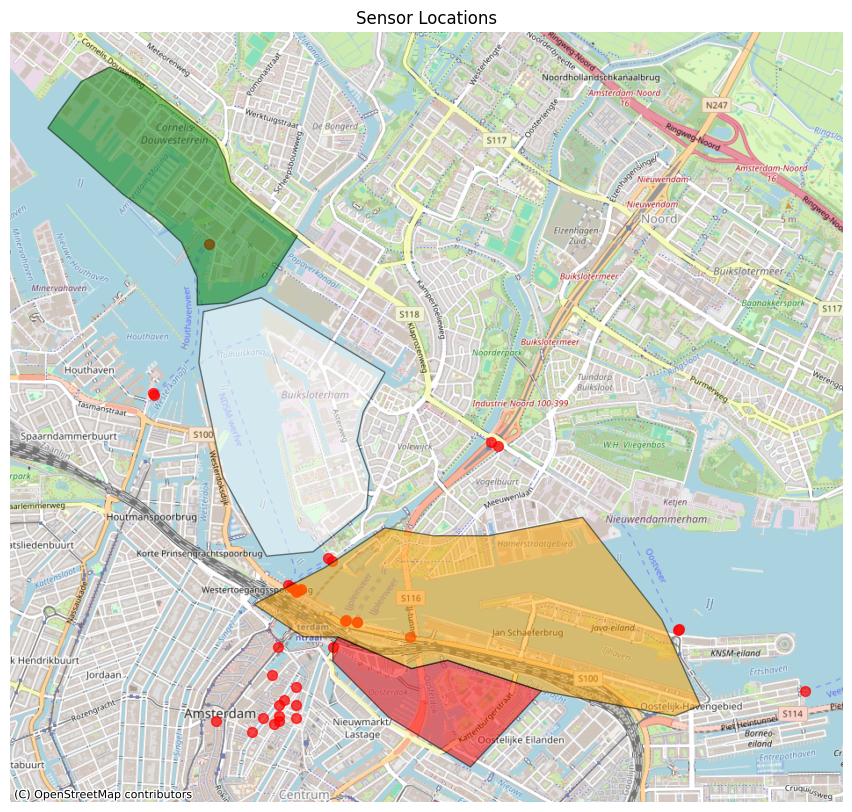

In [5]:
city = "Amsterdam, Netherlands"
gdf_city = ox.geocode_to_gdf(city).to_crs(epsg=3857)

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))

gdf.plot(ax=ax, color='red', markersize=50, alpha=0.7)

gdf_zones.plot(ax=ax, color=gdf_zones['color'], alpha=0.5, edgecolor='black', linewidth=1)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("Sensor Locations")

plt.savefig(
    "sensormap.png",
    dpi=300,
    bbox_inches='tight',
    pad_inches=0
)

plt.show()

In [17]:
# === Imports ===
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import folium
from folium.plugins import HeatMap
import os

# === Inladen van data ===
# Sensor locaties
df_sensors = pd.read_csv("sensor-location.csv", sep=';')
df_sensors[['latitude', 'longitude']] = df_sensors['Lat/Long'].str.split(',', expand=True)
df_sensors['latitude'] = pd.to_numeric(df_sensors['latitude'])
df_sensors['longitude'] = pd.to_numeric(df_sensors['longitude'])

# Omzetten naar GeoDataFrame
geometry = [Point(xy) for xy in zip(df_sensors['longitude'], df_sensors['latitude'])]
gdf_sensors = gpd.GeoDataFrame(df_sensors, geometry=geometry, crs="EPSG:4326")

# Zones inladen
zones = pd.read_csv("Sail plekken Zones.csv")
zones['geometry'] = zones['WKT'].apply(wkt.loads)
gdf_zones = gpd.GeoDataFrame(zones, geometry='geometry', crs="EPSG:4326")

# === Flow data inladen ===
df_flow = pd.read_csv("SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv")

# Lang formaat maken
df_long = df_flow.melt(id_vars=['timestamp'], var_name='sensor', value_name='count')

# Suffix (_0, _180 etc.) weghalen om te kunnen koppelen
df_long['sensor_base'] = df_long['sensor'].str.split('_').str[0]

# Tijd converteren
df_long['timestamp'] = pd.to_datetime(df_long['timestamp'])

# Laatste tijdstap pakken (laatste gemeten moment)
latest_time = df_long['timestamp'].max()
df_latest = df_long[df_long['timestamp'] == latest_time]

# === Data koppelen met sensoren ===
merged = df_latest.merge(gdf_sensors, left_on='sensor_base', right_on='Objectummer', how='left')

# Alleen geldige sensoren (met locatie)
merged = merged.dropna(subset=['latitude', 'longitude'])

# === Heatmap voorbereiden ===
heat_data = [
    [row['latitude'], row['longitude'], row['count']]
    for idx, row in merged.iterrows()
]

# === Interactieve kaart maken ===
m = folium.Map(location=[52.373, 4.9], zoom_start=13, tiles="cartodb positron")

# Zones tekenen
color_map = {
    "Green Zone: Sustainability & Innovation": "green",
    "White zone: Party of meeting": "white",
    "Red zone: Sail's Cultural Living Room": "red",
    "Orange Zone: The Nautical Heart of Sail": "orange"
}

for _, row in gdf_zones.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=color_map.get(row['naam'], "gray"): {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.4
        },
        tooltip=row['naam']
    ).add_to(m)

# Heatmap toevoegen
HeatMap(heat_data, radius=25, blur=20, max_zoom=1).add_to(m)

# Sensorlocaties toevoegen als zwarte punten
for _, row in gdf_sensors.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color='black',
        fill=True,
        fill_color='black',
        popup=row['Locatienaam']
    ).add_to(m)

# === Kaart tonen ===
m.save("sail_crowd_heatmap.html")
#print("✅ Heatmap opgeslagen als 'sail_crowd_heatmap.html'. Open dit bestand in je browser om het te bekijken.")
m

In [39]:
import pandas as pd
import numpy as np
import plotly.express as px

# === Sensorlocaties ===
df_sensors = pd.read_csv("sensor-location.csv", sep=";")
df_sensors[['latitude', 'longitude']] = df_sensors["Lat/Long"].str.split(",", expand=True)
df_sensors["latitude"] = pd.to_numeric(df_sensors["latitude"])
df_sensors["longitude"] = pd.to_numeric(df_sensors["longitude"])

# === Flowdata ===
df_flow = pd.read_csv("SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv")
df_flow["timestamp"] = pd.to_datetime(df_flow["timestamp"])

# === Transformeren naar lang formaat ===
df_long = df_flow.melt(id_vars=["timestamp"], var_name="sensor_dir", value_name="count")
df_long["sensor_base"] = df_long["sensor_dir"].str.split("_").str[0]

# === Merge met sensoren ===
merged = df_long.merge(df_sensors, left_on="sensor_base", right_on="Objectummer", how="left")
merged = merged.dropna(subset=["latitude", "longitude"])

# === Normaliseren ===
merged["count"] = merged["count"].clip(lower=0)  # negatieve waardes vermijden
merged["count_norm"] = merged["count"] / merged["count"].max()

# === Minder tijdstappen voor performance ===
unique_times = sorted(merged["timestamp"].unique())
sampled_times = unique_times[::10]  # elke ~30 min
merged = merged[merged["timestamp"].isin(sampled_times)]

# === Heatmap in Plotly ===
fig = px.density_mapbox(
    merged,
    lat="latitude",
    lon="longitude",
    z="count_norm",
    radius=18,                    # kleinere radius → meer detail
    center=dict(lat=52.373, lon=4.9),
    zoom=12.5,
    mapbox_style="carto-positron",
    color_continuous_scale="inferno",
    animation_frame="timestamp",
    opacity=0.75                  # maakt de heat subtieler
)

fig.update_layout(
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    title="Bewegende Heatmap van Publieksdrukte tijdens SAIL 2025",
    coloraxis_showscale=False,
)

fig.write_html("sail_heatmap_vloeiend_light.html")
print("✅ Heatmap opgeslagen als 'sail_heatmap_vloeiend_light.html'. Open dit bestand in je browser.")

/var/folders/bx/gy1_8c5d28qdczv323n3lfl40000gn/T/ipykernel_19277/2736306813.py:33: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



✅ Heatmap opgeslagen als 'sail_heatmap_vloeiend_light.html'. Open dit bestand in je browser.
